# Телеком - задача проекта

<a id='intro'></a>

## Оглавление

[Введение](#chapter2)

[Исследование задачи](#chapter3)

[Подготовка данных](#chapter4)

[Обучение моделей](#chapter5)

[Борьба с дисбалансом](#chapter6)

[Общий вывод](#chapter7)

<a id='chapter2'></a>

## Введение


Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.


Цель данной работы: спрогнозировать уход клиента из компании. Для решения этой задачи мы должны построить модель для задачи классификации, которая сможет определить уйдет данный клиент или нет.

В качестве исходной информации нам передали данные о поведении клиентов, их персональных данных, информацию об их тарифах и договорах.


<a id='chapter3'></a>

## Исследование задачи


Загрузим необходимые библиотеки для последующей работы.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


Все данные находятся в четырех файлах. Загрузим их в разные датасеты.


In [2]:
data_contract = pd.read_csv('/datasets/final_provider/contract.csv')
data_personal = pd.read_csv('/datasets/final_provider/personal.csv')
data_internet = pd.read_csv('/datasets/final_provider/internet.csv')
data_phone = pd.read_csv('/datasets/final_provider/phone.csv')


Объединим теперь все данные в один датасет по идентификационному номеру клиента.


In [3]:
data = data_contract.merge(data_personal, on='customerID', how='left')
data = data.merge(data_internet, on='customerID', how='left')
data = data.merge(data_phone, on='customerID', how='left')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB



Получилась таблица с 20 столбцами:

- *customerID* - идентификационный номер клиента;

- *BeginDate* - дата заключения договора;

- *EndDate* - дата расторжения договора;

- *Type* - тип подключения услуги;

- *PaperlessBilling* - безбумажный счет;

- *PaymentMethod* - способ оплаты;

- *MonthlyCharges* - сумма ежемесячной оплаты;

- *TotalCharges* - общая оплата;

- *gender* - пол клиента;

- *SeniorCitizen* - является ли клиент пенсионером;

- *Partner* - состоит ли клиент в браке;

- *Dependents* - имеет ли клиент иждивенцев;

- *InternetService* - тип предоставляемого интернет-подключения;

- *OnlineSecurity* - подключена ли услуга блокировки небезопасных сайтов;

- *OnlineBackup* - подключено ли облачное хранилище файлов для резервного копирования;

- *DeviceProtection* - подключена ли услуга защиты устройства - антивирус;

- *TechSupport* - подключена ли выделенная линия технической поддержки;

- *StreamingTV* - подключена ли услуга стримингового телевидения;

- *StreamingMovies* - подключен ли каталог фильмов;

- *MultipleLines* - подключен ли телефонный аппарат к нескольким линиям одновременно.



Проверим данные на наличие дублирующихся строк.


In [5]:
data.duplicated().sum()

0


Не все столбцы, содержащиеся в таблице, требуются для последующего решения задачи. Например, столбцы с идентификационным номером клиента и столбец с датой заключения договора. Однако мы можем создать новый столбец, который вычисляет время, в течение которого клиент пользовался услугами компании.

Для этого преобразуем тип данных столбца *BeginDate* в формат дат. В столбец *date* скопируем столбец *EndDate* с той поправкой, что если договор еще не расторжен, то дата будет равна 01 февраля 2020 года - дате актуальности таблиц.


In [6]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['date'] = data['EndDate']
data.loc[data['date']=='No', 'date'] = '2020-02-01'
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


Теперь из столбца *date* вычтем столбец *BeginDate* и получим количество дней, в течение которых клиент пользовался услугами компании.


In [7]:
data['time'] = (data['date'] - data['BeginDate']).dt.days
data['time'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: time, dtype: float64


Видим, что минимальное количество дней, - 0. Очевидно, это те клиенты, которые только что заключили договор. Таких людей совсем немного, мы можем их исключить из анализа.


In [8]:
data[data['time']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 488 to 6754
Data columns (total 22 columns):
customerID          11 non-null object
BeginDate           11 non-null datetime64[ns]
EndDate             11 non-null object
Type                11 non-null object
PaperlessBilling    11 non-null object
PaymentMethod       11 non-null object
MonthlyCharges      11 non-null float64
TotalCharges        11 non-null object
gender              11 non-null object
SeniorCitizen       11 non-null int64
Partner             11 non-null object
Dependents          11 non-null object
InternetService     5 non-null object
OnlineSecurity      5 non-null object
OnlineBackup        5 non-null object
DeviceProtection    5 non-null object
TechSupport         5 non-null object
StreamingTV         5 non-null object
StreamingMovies     5 non-null object
MultipleLines       9 non-null object
date                11 non-null datetime64[ns]
time                11 non-null int64
dtypes: datetime64[ns](2), f

In [9]:
data = data.loc[data['time']!=0]
data.reset_index(inplace=True, drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null object
OnlineBackup        5512 non-null object
DeviceProtection    5512 non-null object
TechSupport         5512 non-null object
StreamingTV         5512 non-null object
StreamingMovies     5512 non-null object
MultipleLines       6352 non-null object
date                7032 non-null datetime64[ns]
time            


Теперь удалим столбцы, которые в дальнейшем не будут влиять на обучение.


In [10]:
data.drop(['customerID', 'BeginDate', 'date'], axis='columns', inplace=True)


Изменим тип данных столбца *TotalCharges* - это значение должно быть числом.


In [11]:
data['TotalCharges'] = data['TotalCharges'].astype('Float64')


Проверим данные на наличие неопределенных значений.


In [12]:
data.isna().sum()

EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
time                   0
dtype: int64


Видим, что неопределенные значения встречаются в толбцах *InternetService*, *OnlineSecurity*, *OnlineBackup*, *DeviceProtection*, *TechSupport*, *StreamingTV*, *StreamingMovies* и *MultipleLines*.

Можно предположить, что неопределенные значения у клиентов, которые не пользуются данными услугами, поэтому мы можем заменить эти значения на **No**.


In [13]:
data.loc[data['InternetService'].isna(), 'InternetService'] = 'No'
data.loc[data['OnlineSecurity'].isna(), 'OnlineSecurity'] = 'No'
data.loc[data['OnlineBackup'].isna(), 'OnlineBackup'] = 'No'
data.loc[data['DeviceProtection'].isna(), 'DeviceProtection'] = 'No'
data.loc[data['TechSupport'].isna(), 'TechSupport'] = 'No'
data.loc[data['StreamingTV'].isna(), 'StreamingTV'] = 'No'
data.loc[data['StreamingMovies'].isna(), 'StreamingMovies'] = 'No'
data.loc[data['MultipleLines'].isna(), 'MultipleLines'] = 'No'
data.isna().sum()

EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
time                0
dtype: int64


Теперь пропусков в данных нет.



Посмотрим общую статистику по столбцам.


In [14]:
data.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,time
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.162400,987.538538
std,30.085974,2266.771362,0.368844,747.153663
min,18.250000,18.800000,0.000000,30.000000
25%,35.587500,401.450000,0.000000,275.000000
50%,70.350000,1397.475000,0.000000,883.000000
75%,89.862500,3794.737500,0.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


In [15]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)


Значения признаков выглядят правдоподобно - нет таких артефактов, как отрицательные значения. Столбец с полом клиента принимает только два значения: мужской и женский.



Признаки, принимающие значения только *Yes* или *No*, преобразуем в вид *1* или *0*, как это указано в столбце *SeniorCitizen*.


In [16]:
data['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [17]:
data.loc[data['Partner'] != 'No', 'Partner'] = 1
data.loc[data['Partner'] == 'No', 'Partner'] = 0
data.loc[data['PaperlessBilling'] != 'No', 'PaperlessBilling'] = 1
data.loc[data['PaperlessBilling'] == 'No', 'PaperlessBilling'] = 0
data.loc[data['Dependents'] != 'No', 'Dependents'] = 1
data.loc[data['Dependents'] == 'No', 'Dependents'] = 0
data.loc[data['InternetService'] != 'No', 'InternetService'] = 1
data.loc[data['InternetService'] == 'No', 'InternetService'] = 0
data.loc[data['OnlineSecurity'] != 'No', 'OnlineSecurity'] = 1
data.loc[data['OnlineSecurity'] == 'No', 'OnlineSecurity'] = 0
data.loc[data['OnlineBackup'] != 'No', 'OnlineBackup'] = 1
data.loc[data['OnlineBackup'] == 'No', 'OnlineBackup'] = 0
data.loc[data['DeviceProtection'] != 'No', 'DeviceProtection'] = 1
data.loc[data['DeviceProtection'] == 'No', 'DeviceProtection'] = 0
data.loc[data['TechSupport'] != 'No', 'TechSupport'] = 1
data.loc[data['TechSupport'] == 'No', 'TechSupport'] = 0
data.loc[data['StreamingTV'] != 'No', 'StreamingTV'] = 1
data.loc[data['StreamingTV'] == 'No', 'StreamingTV'] = 0
data.loc[data['StreamingMovies'] != 'No', 'StreamingMovies'] = 1
data.loc[data['StreamingMovies'] == 'No', 'StreamingMovies'] = 0
data.loc[data['MultipleLines'] != 'No', 'MultipleLines'] = 1
data.loc[data['MultipleLines'] == 'No', 'MultipleLines'] = 0


Проверим корреляцию между столбцами *MonthlyCharges*, *TotalCharges* и *time*. Если корреляция есть, то один из столбцов можно будет также удалить.


In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,time
PaperlessBilling,1,0.35193,0.15783,0.156258,-0.0139567,-0.110131,0.320592,-0.00405125,0.127056,0.104079,0.0375359,0.224241,0.211583,0.163746,0.00472887
MonthlyCharges,0.35193,1,0.651065,0.219874,0.097825,-0.112343,0.763191,0.296447,0.441529,0.482607,0.338301,0.629668,0.627235,0.490912,0.246715
TotalCharges,0.15783,0.651065,1,0.102411,0.319072,0.0646532,0.374878,0.412619,0.5101,0.522881,0.432868,0.515709,0.519867,0.469042,0.825811
SeniorCitizen,0.156258,0.219874,0.102411,1,0.0169566,-0.21055,0.182519,-0.0385764,0.0666628,0.0595139,-0.0605768,0.105445,0.119842,0.142996,0.01563
Partner,-0.0139567,0.097825,0.319072,0.0169566,1,0.452269,0.00028552,0.143346,0.141849,0.153556,0.120206,0.124483,0.118108,0.142561,0.381924
Dependents,-0.110131,-0.112343,0.0646532,-0.21055,0.452269,1,-0.138383,0.0807855,0.0236388,0.0138997,0.0630532,-0.0164987,-0.0383749,-0.0243067,0.163442
InternetService,0.320592,0.763191,0.374878,0.182519,0.00028552,-0.138383,1,0.332799,0.38099,0.380151,0.335695,0.414951,0.41845,0.210794,0.0374167
OnlineSecurity,-0.00405125,0.296447,0.412619,-0.0385764,0.143346,0.0807855,0.332799,1,0.283285,0.274875,0.354458,0.175514,0.187426,0.098592,0.328299
OnlineBackup,0.127056,0.441529,0.5101,0.0666628,0.141849,0.0236388,0.38099,0.283285,1,0.303058,0.293705,0.281601,0.274523,0.202228,0.3611
DeviceProtection,0.104079,0.482607,0.522881,0.0595139,0.153556,0.0138997,0.380151,0.274875,0.303058,1,0.33285,0.389924,0.402309,0.201733,0.361469



Видим, что столбец *TotalCharges* коррелируется со столбцом *time*. Удалим его, оставив *time*.


In [19]:
data.drop(['TotalCharges'], axis='columns', inplace=True)

[К оглавлению](#intro)

<a id='chapter4'></a>

## Подготовка данных


Перед нами стоит задача классификации - нам необходимо спрогнозировать уход клиента из компании. Значит целевым признаком в данном случае будет несколько модифицированный столбец *EndDate*. В данном случае нам не важно когда именно клиент расторг договор с компанией, а лишь сам факт этого. Создадим новый целевой признак *target*. Он примет значение 0, если клиент все еще пользуется услугами, и 1, если клиент расторг договор.


In [20]:
data['target'] = 0
data.loc[data['EndDate'] != 'No', 'target'] = 1


Теперь сам столбец *EndDate* мы также можем удалить.


In [21]:
data.drop(['EndDate'], axis='columns', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 18 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
InternetService     7032 non-null int64
OnlineSecurity      7032 non-null int64
OnlineBackup        7032 non-null int64
DeviceProtection    7032 non-null int64
TechSupport         7032 non-null int64
StreamingTV         7032 non-null int64
StreamingMovies     7032 non-null int64
MultipleLines       7032 non-null int64
time                7032 non-null int64
target              7032 non-null int64
dtypes: float64(1), int64(14), object(3)
memory usage: 989.0+ KB



Построим гистограмму распределения целевого признака.


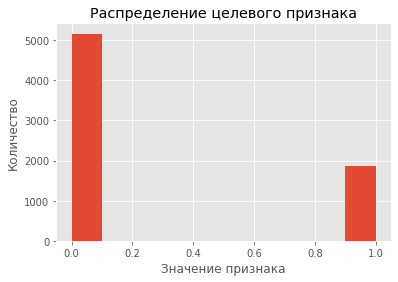

In [22]:
data['target'].hist()
plt.title('Распределение целевого признака')
plt.xlabel("Значение признака")
plt.ylabel("Количество")
plt.show()


Видим, что значение целевого признака *1*, т.е. "клиент расторг договор", встречается гораздо реже, чем значение *0*. Вероятно, при обучении модели в дальнейшем потребуется учесть этот дисбаланс классов.



Объявим признаки.


In [23]:
target = data['target']
feature = data.drop(['target'], axis=1)


Сейчас нам нужно подготовить данные перед обучением модели. Обучить модель на тех данных, что у нас есть, не получится: признаки могут быть только численные, а наши данные содержат и категориальные признаки. Преобразуем их в численные техникой прямого кодирования.


In [24]:
feature = pd.get_dummies(feature, columns=['Type', 'PaymentMethod', 'gender'], drop_first=True)
feature.head()

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,time,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male
0,1,29.85,0,1,0,1,0,1,0,0,0,0,0,31,0,0,0,1,0,0
1,0,56.95,0,0,0,1,1,0,1,0,0,0,0,1036,1,0,0,0,1,1
2,1,53.85,0,0,0,1,1,1,0,0,0,0,0,61,0,0,0,0,1,1
3,0,42.30,0,0,0,1,1,0,1,1,0,0,0,1371,1,0,0,0,0,1
4,1,70.70,0,0,0,1,0,0,0,0,0,0,0,61,0,0,0,1,0,0



Теперь у нас появились новые столбцы, вместо <i>gender</i> - <i>gender_Male</i>, который принимает значение 0 (клиент женского пола) или 1 (клиент мужского пола).



Тестовой выборки для предсказывания значений у нас нет. Поэтому необходимо общий набор данных разделить на две части: обучающую выборку и тестовую.


In [25]:
#выделим тестовую выборку
features_train, features_test, target_train, target_test = (
train_test_split(feature, target, test_size=0.2, random_state=0, stratify=target)
)
print('Количество объектов в обучающей выборке:', len(features_train))
print('Количество объектов в тестовой выборке:', len(features_test))

Количество объектов в обучающей выборке: 5625
Количество объектов в тестовой выборке: 1407


In [26]:
print('Значений класса "1" в обучающей выборке: {:.1%}'.format(target_train.sum()/len(target_train)))
print('Значений класса "1" в тестовой выборке: {:.1%}'.format(target_test.sum()/len(target_test)))

Значений класса "1" в обучающей выборке: 26.6%
Значений класса "1" в тестовой выборке: 26.6%



Теперь, после разделения набора данных на три выборки, нам необходимо масштабировать признаки. Если в одном столбце значения и их разбросы больше, чем в другом, то алгоритм решит, что этот признак важнее, а это не так: все признаки важны.


In [27]:
#численные признаки
numeric = ['MonthlyCharges', 'time']
#масштабирование
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,time,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male
3780,1,0.360948,0,1,1,1,0,0,0,0,0,0,1,-0.219880,0,0,0,0,0,1
1588,0,-1.535042,0,1,1,0,0,0,0,0,0,0,0,-1.157282,0,0,0,0,1,1
2927,1,1.622164,1,1,0,1,0,1,1,1,1,1,1,0.925387,0,1,0,1,0,1
198,1,1.577180,0,1,1,1,0,1,1,1,1,1,1,1.616034,0,1,0,0,0,1
4504,1,0.352617,1,0,0,1,0,1,1,1,1,0,1,1.536911,0,1,0,0,0,0


[К оглавлению](#intro)

<a id='chapter5'></a>

## Обучение моделей


В значениях целевого признака наблюдается сильный дисбаланс классов - значений класса "1" в четыре раза меньше, чем значений класса "0". В данном разделе попробуем обучить модель без учета дисбаланса.



Обучим четыре алгоритма классификации:

* дерево решений

* случайный лес

* логистическая регрессия

* градиентный бустинг



Построим модель с предельно большим значением ROC-AUC.


In [28]:
#функция для обучения дерева решений
def Tree(features_train, target_train, params):
    dtc = DecisionTreeClassifier()
    dtc_grid = GridSearchCV(estimator=dtc, param_grid=params, scoring='roc_auc', cv=5)
    model_dtc = dtc_grid.fit(features_train, target_train)
    return model_dtc.best_params_, model_dtc.best_score_

In [29]:
#функция для обучения случайного леса
def Forest(features_train, target_train, params):
    rfc = RandomForestClassifier()
    rfc_grid = GridSearchCV(estimator=rfc, param_grid=params, scoring='roc_auc', cv=5)
    model_rfc = rfc_grid.fit(features_train, target_train)
    return model_rfc.best_params_, model_rfc.best_score_

In [30]:
#функция для обучения алгоритма градиентного бустинга
def Cat(features_train, target_train, params):
    clf = CatBoostClassifier()
    clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring='roc_auc', cv=5)
    model_clf = clf_grid.fit(features_train, target_train)
    return model_clf.best_params_, model_clf.best_score_, clf_grid

In [31]:
#функция для построения значимости признаков
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    df = pd.DataFrame(data)
    df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    plt.title(model_type)
    plt.xlabel('Важность признаков')
    plt.ylabel('Признаки')

### Дерево решений


Построим модель с помощью дерева решений и подберем глубину дерева с наилучшим значением ROC-AUC.


In [32]:
param_tree = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'random_state': [0]}
best_depth_tree, best_result_tree = Tree(features_train, target_train, param_tree)
print('ROC-AUC:', best_result_tree, 'с глубиной', best_depth_tree['max_depth'])

ROC-AUC: 0.8451877525569492 с глубиной 6



Проверим значение ROC-AUC и Accuracy на тестовой выборке.


In [33]:
model_tree = DecisionTreeClassifier(max_depth=best_depth_tree['max_depth'], random_state=best_depth_tree['random_state'])
model_tree.fit(features_train, target_train)
predict = model_tree.predict(features_test)
probabilities = model_tree.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
auc_roc_tree = roc_auc_score(target_test, proba_one_test)
accuracy_tree = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_tree)
print('Accuracy:', accuracy_tree)

AUC-ROC: 0.8418577322683011
Accuracy: 0.8194740582800284


### Случайный лес

In [34]:
param_forest = {'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'random_state': [0]}
best_param_forest, best_result_forest = Forest(features_train, target_train, param_forest)
print('ROC-AUC:', best_result_forest, 'с глубиной', best_param_forest['max_depth'], 'и количеством деревьев', best_param_forest['n_estimators'])

ROC-AUC: 0.8555544308307756 с глубиной 8 и количеством деревьев 50


In [35]:
model_forest = RandomForestClassifier(n_estimators=best_param_forest['n_estimators'],
                                      max_depth=best_param_forest['max_depth'],
                                      random_state=best_param_forest['random_state'])
model_forest.fit(features_train, target_train)
predict = model_forest.predict(features_test)
probabilities = model_forest.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
auc_roc_forest = roc_auc_score(target_test, proba_one_test)
accuracy_forest = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_forest)
print('Accuracy:', accuracy_forest)

AUC-ROC: 0.8609806855066237
Accuracy: 0.8137882018479033


### Логистическая регрессия

In [36]:
#создаем модель логистической регрессии
model_log = LogisticRegression(random_state=0, solver='liblinear')
#обучаем модель
model_log.fit(features_train, target_train)
predict = model_log.predict(features_test)
#предсказываем результаты
probabilities = model_log.predict_proba(features_test)
proba_one_valid = probabilities[:, 1]
auc_roc_log = roc_auc_score(target_test, proba_one_test)
accuracy_log = accuracy_score(target_test, predict)
print('ROC-AUC:', auc_roc_log)
print('Accuracy:', accuracy_log)

ROC-AUC: 0.8609806855066237
Accuracy: 0.8045486851457001


### Градиентный бустинг

In [37]:
param_cat = {'iterations': [100, 200, 500], 'depth': [1, 2, 3, 4, 5, 6], 'loss_function': ['Logloss'], 
         'logging_level': ['Silent'], 'random_seed': [0]}
best_param_cat, best_result_cat, grid_cat = Cat(features_train, target_train, param_cat)
print('ROC-AUC:', best_result_cat)

ROC-AUC: 0.9079121688922722


In [38]:
model_cat = CatBoostClassifier(iterations=best_param_cat['iterations'],
                               loss_function='Logloss', depth=best_param_cat['depth'],
                               logging_level='Silent', random_seed=best_param_cat['random_seed'])
model_cat.fit(features_train, target_train)
probabilities = model_cat.predict_proba(features_test)
proba_one_valid = probabilities[:, 1]
predict = model_cat.predict(features_test)
auc_roc_cat = roc_auc_score(target_test, proba_one_valid)
accuracy_cat = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_cat)
print('Accuracy:', accuracy_cat)

AUC-ROC: 0.9243468222455751
Accuracy: 0.8742004264392325



Сведем все результаты в таблицу.


In [39]:
final = pd.DataFrame(index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия', 'Градиентный бустинг'],
                     columns=['AUC-ROC', 'Accuracy'])
final.loc['Дерево решений', 'Accuracy'] = accuracy_tree
final.loc['Дерево решений', 'AUC-ROC'] = auc_roc_tree
final.loc['Случайный лес', 'Accuracy'] = accuracy_forest
final.loc['Случайный лес', 'AUC-ROC'] = auc_roc_forest
final.loc['Логистическая регрессия', 'Accuracy'] = accuracy_log
final.loc['Логистическая регрессия', 'AUC-ROC'] = auc_roc_log
final.loc['Градиентный бустинг', 'Accuracy'] = accuracy_cat
final.loc['Градиентный бустинг', 'AUC-ROC'] = auc_roc_cat

### Вывод


Итак, подведем промежуточный итог работы алгоритмов.


In [40]:
final.head().style.highlight_max(color='yellowgreen', subset=['Accuracy', 'AUC-ROC'])

,AUC-ROC,Accuracy
Дерево решений,0.841858,0.819474
Случайный лес,0.860981,0.813788
Логистическая регрессия,0.860981,0.804549
Градиентный бустинг,0.924347,0.8742


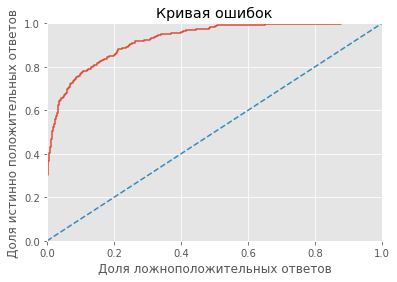

AUC-ROC: 0.9243468222455751


In [41]:
#построение кривой ошибок
probabilities = model_cat.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, proba_one_test)
plt.figure()
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('Доля ложноположительных ответов')
plt.ylabel('Доля истинно положительных ответов')
plt.title('Кривая ошибок')
plt.show()
auc_roc_log = roc_auc_score(target_test, proba_one_test)
print('AUC-ROC:', auc_roc_cat)


Видим, что метод **CatBoostClassifier** дает очень хороший результат предсказаний даже с дисбалансом классов.


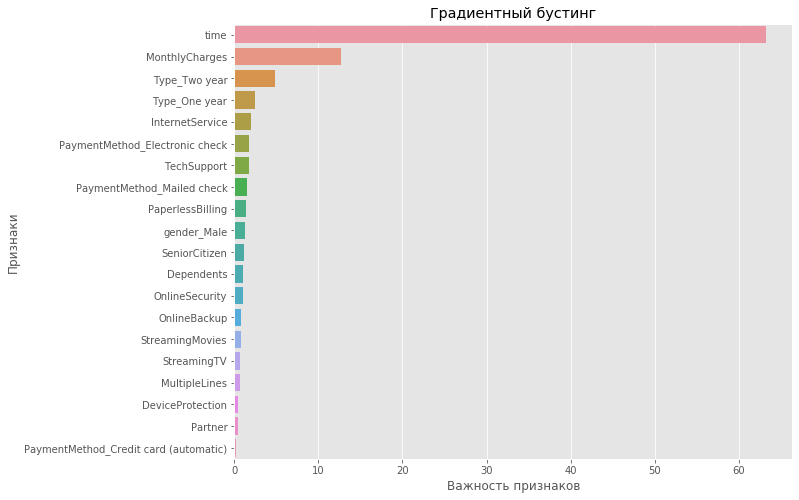

In [42]:
plot_feature_importance(grid_cat.best_estimator_.feature_importances_, features_train.columns, 'Градиентный бустинг')


При этом наибольшую значимость на то, расторгнет ли клиент договор с компанией, влияет впемя, в течение которого клиент пользуется услугами компании.


[К оглавлению](#intro)

<a id='chapter6'></a>

## Борьба с дисбалансом


В этой части мы попробуем улучшить качество моделей, учитывая дисбаланс классов. Для этого увеличим выборку техникой upsampling и уменьшим выборку методом downsampling.


### Увеличение выборки


* разделим обучающую выборку на отрицательные и положительные объекты

* скопируем четыре раза положительные объекты

* с учетом полученных данных создадим новую выборку

* перемешаем данные


In [43]:
#функция upsampling
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_ups = pd.concat([features_zeros]+[features_ones]*repeat)
    target_ups = pd.concat([target_zeros]+[target_ones]*repeat)
    features_ups, target_ups = shuffle(features_ups, target_ups, random_state=0)
    return features_ups, target_ups

In [44]:
features_ups, target_ups = upsample(features_train, target_train, 4)


Теперь проведем расчет трех алгоритмов, используя увеличенную выборку.


#### Дерево решений

In [45]:
best_depth_tree_up, best_result_tree_up = Tree(features_ups, target_ups, param_tree)
print('ROC-AUC:', best_result_tree_up, 'с глубиной', best_depth_tree_up['max_depth'])

ROC-AUC: 0.8953793719176918 с глубиной 11


In [46]:
model_tree_up = DecisionTreeClassifier(max_depth=best_depth_tree_up['max_depth'], random_state=best_depth_tree_up['random_state'])
model_tree_up.fit(features_ups, target_ups)
predict = model_tree_up.predict(features_test)
probabilities = model_tree_up.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
auc_roc_tree_up = roc_auc_score(target_test, proba_one_test)
accuracy_tree_up = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_tree_up)
print('Accuracy:', accuracy_tree_up)

AUC-ROC: 0.8046678849309679
Accuracy: 0.7277896233120114


#### Случайный лес

In [47]:
best_param_forest_up, best_result_forest_up = Forest(features_ups, target_ups, param_forest)
print('ROC-AUC:', best_result_forest_up, 'с глубиной', best_param_forest_up['max_depth'], 'и количеством деревьев', best_param_forest_up['n_estimators'])

ROC-AUC: 0.9832816409824516 с глубиной 15 и количеством деревьев 50


In [48]:
model_forest_up = RandomForestClassifier(n_estimators=best_param_forest_up['n_estimators'],
                                      max_depth=best_param_forest_up['max_depth'],
                                      random_state=best_param_forest_up['random_state'])
model_forest_up.fit(features_ups, target_ups)
predict = model_forest_up.predict(features_test)
probabilities = model_forest_up.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
auc_roc_forest_up = roc_auc_score(target_test, proba_one_test)
accuracy_forest_up = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_forest_up)
print('Accuracy:', accuracy_forest_up)

AUC-ROC: 0.842504827329154
Accuracy: 0.7810945273631841


#### Градиентный бустинг

In [49]:
best_param_cat_up, best_result_cat_up, grid_cat_up = Cat(features_ups, target_ups, param_cat)
print('ROC-AUC:', best_result_cat_up)

ROC-AUC: 0.9594126304793216


In [50]:
model_cat_up = CatBoostClassifier(iterations=best_param_cat_up['iterations'],
                               loss_function='Logloss', depth=best_param_cat_up['depth'],
                               logging_level='Silent', random_seed=best_param_cat_up['random_seed'])
model_cat_up.fit(features_ups, target_ups)
probabilities = model_cat_up.predict_proba(features_test)
proba_one_valid = probabilities[:, 1]
predict = model_cat_up.predict(features_test)
auc_roc_cat_up = roc_auc_score(target_test, proba_one_valid)
accuracy_cat_up = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_cat_up)
print('Accuracy:', accuracy_cat_up)

AUC-ROC: 0.9196023212594024
Accuracy: 0.8208955223880597


### Уменьшение выборки


* разделим обучающую выборку на отрицательные и положительные объекты

* отбрасываем часть отрицательных объектов

* с учетом полученных данных создадим новую выборку

* перемешаем данные


In [51]:
#функция downsampling
def downsample(features, target, frak):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_down = pd.concat([features_zeros.sample(frac=frak, random_state=0)]+[features_ones])
    target_down = pd.concat([target_zeros.sample(frac=frak, random_state=0)]+[target_ones])
    features_down, target_down = shuffle(features_down, target_down, random_state=0)
    return features_down, target_down

In [52]:
features_down, target_down = downsample(features_train, target_train, 0.25)

#### Дерево решений

In [53]:
best_depth_tree_down, best_result_tree_down = Tree(features_down, target_down, param_tree)
print('ROC-AUC:', best_result_tree_down, 'с глубиной', best_depth_tree_down['max_depth'])

ROC-AUC: 0.827997292912302 с глубиной 5


In [54]:
model_tree_up = DecisionTreeClassifier(max_depth=best_depth_tree_up['max_depth'], random_state=best_depth_tree_up['random_state'])
model_tree_up.fit(features_ups, target_ups)
predict = model_tree_up.predict(features_test)
probabilities = model_tree_up.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
auc_roc_tree_up = roc_auc_score(target_test, proba_one_test)
accuracy_tree_up = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_tree_up)
print('Accuracy:', accuracy_tree_up)

AUC-ROC: 0.8046678849309679
Accuracy: 0.7277896233120114


#### Случайный лес

In [55]:
best_param_forest_down, best_result_forest_down = Forest(features_down, target_down, param_forest)
print('ROC-AUC:', best_result_forest_down, 'с глубиной', best_param_forest_down['max_depth'], 'и количеством деревьев', best_param_forest_down['n_estimators'])

ROC-AUC: 0.8478717533778928 с глубиной 6 и количеством деревьев 50


In [56]:
model_forest_down = RandomForestClassifier(n_estimators=best_param_forest_down['n_estimators'],
                                      max_depth=best_param_forest_down['max_depth'],
                                      random_state=best_param_forest_down['random_state'])
model_forest_down.fit(features_down, target_down)
predict = model_forest_down.predict(features_test)
probabilities = model_forest_down.predict_proba(features_test)
proba_one_test = probabilities[:, 1]
auc_roc_forest_down = roc_auc_score(target_test, proba_one_test)
accuracy_forest_down = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_forest_down)
print('Accuracy:', accuracy_forest_down)

AUC-ROC: 0.8484322180865658
Accuracy: 0.6965174129353234


#### Градиентный бустинг

In [57]:
#лучшие гиперпараметры для градиентного бустинга
best_param_cat_down, best_result_cat_down, grid_cat_down = Cat(features_down, target_down, param_cat)
print('ROC-AUC:', best_result_cat_down)

ROC-AUC: 0.8766385010405477


In [58]:
#обучаем модель на полученных гиперпараметрах
model_cat_down = CatBoostClassifier(iterations=best_param_cat_down['iterations'],
                               loss_function='Logloss', depth=best_param_cat_down['depth'],
                               logging_level='Silent', random_seed=best_param_cat_down['random_seed'])
model_cat_down.fit(features_down, target_down)
probabilities = model_cat_down.predict_proba(features_test)
proba_one_valid = probabilities[:, 1]
predict = model_cat_down.predict(features_test)
auc_roc_cat_down = roc_auc_score(target_test, proba_one_valid)
accuracy_cat_down = accuracy_score(target_test, predict)
print('AUC-ROC:', auc_roc_cat_down)
print('Accuracy:', accuracy_cat_down)

AUC-ROC: 0.8863571654130279
Accuracy: 0.7604832977967306


<a id='chapter7'></a>

## Вывод


В данной работе мы изучили поведение клиентов "Ниединогоразрыва.ком" для создания модели, позволяющей спрогнозировать уход клиента из компании.

Изучая исходную информацию - время пользования услугами компании, информацию о тарифе клиента, об активности пользования предоставляемыми услугами и прочее - мы построили несколько моделей, позволяющих определить целевой признак, а именно факт расторжения клиентом договора с компанией.

Мы построили модели:

* дерева решений с различными значениями глубины дерева

* случайного леса с варьирующимися значениями количества деревьев и глубины

* логистической регрессии

* градиентного бустинга

Также мы проанализировали несколько способов борьбы с дисбалансом классом: увеличение выборки редкого класса и уменьшение выборки часто встречающегося класса, однако ни один из них не показал удовлетворительного результата. Модель при этом просто переобучается.

Наилучший результат показала модель градиентного бустинга: AUC-ROC на тестовой выборке равен 0.92, Acuracy - 0.87, что является хорошим результатом. При этом наибольшее влияние на то, расторгнет ли клиент договор с компанией, оказывает время, в течение которого клиент пользуется услугами, а также его абонентская плата.

Как итог, мы можем рекомендовать использовать данную модель для прогноза ухода клиентов из компании.
